In [ ]:
pip install einops

In [ ]:
pip install sentencepiece

In [ ]:
pip install einops_exts

In [ ]:
pip install torch

In [ ]:
pip install torchvision

In [ ]:
pip install matplotlib

In [ ]:
pip install transformers

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch import Tensor, nn, einsum
from torchvision import datasets, transforms
from torch.cuda import is_available
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from einops import rearrange
from einops.layers.torch import Rearrange
from einops_exts import rearrange_many, repeat_many
from einops_exts.torch import EinopsToAndFrom
import zipfile
import math

2024-02-04 21:21:49.908346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
with zipfile.ZipFile('Flickr8k/Images.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Hyperparameters

In [3]:
# training hyperparameters
batch_size = 32
n_epoch = 5000
learning_rate = 1e-3
# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
n_feat = 128 # hidden dimension feature
n_cfeat = 512 # word vector
height = 64 # 64x64 image
save_dir = './weights_pocho/'
# diffusion hyperparameters
timesteps = 500
MAX_TEXT_LEN = 64

# Diffusion Model

## Class

In [4]:
class Diffusion_Models():
  # return beta_sqrt, alpha, alpha_sqrt, gamma, gamma_sqrt for noise and denoise image
  def __init__(self, timesteps, beta1=1e-4, beta2=0.02):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    beta = torch.linspace(beta1, beta2, timesteps + 1, device='cpu')
    alpha = 1 - beta
    one_by_sqrt_alpha = 1./alpha.sqrt()
    gamma = torch.cumprod(alpha, axis=0)
    gamma[0] = 1
    sqrt_one_minus_gamma = (1. - gamma).sqrt()
    beta_by_sqrt_one_minus_gamma = beta/sqrt_one_minus_gamma
    self.noise_schedule_dict = {'alpha':alpha, 'sqrt_alpha':alpha.sqrt(),
                   'beta':beta, 'sqrt_beta':beta.sqrt(),
                   'gamma':gamma, 'sqrt_gamma':gamma.sqrt(),
                   'one_by_sqrt_alpha':one_by_sqrt_alpha,
                   'sqrt_one_minus_gamma':sqrt_one_minus_gamma,
                   'beta_by_sqrt_one_minus_gamma':beta_by_sqrt_one_minus_gamma}
    self.timesteps = timesteps
    self.transform = transforms.Compose([
          transforms.Normalize(0.5,0.5)
          ])

  def show_noise_schedule(self):
    rows = 5
    cols = 2
    plt.figure(figsize=(16,16))
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.subplot(rows, cols, i + 1)
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def show_noise_schedule2(self):
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.figure(figsize=(4,4))
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def noise_image(self, x_0, time, noise=None):
    if noise is None:
      noise = torch.randn_like(x_0)
    img = self.noise_schedule_dict['sqrt_gamma'].to(self.device)[time, None, None, None] * x_0.to(self.device) + (self.noise_schedule_dict['sqrt_one_minus_gamma'].to(self.device)[time, None, None, None]) * noise.to(self.device)
    return img

  def unorm(self, img):
    img = torch.tensor(img)
    img = torch.clamp(img, -1.,1.)
    min, max = torch.aminmax(img)
    img = (img - min)/(max-min)
    return img

  def simulate_forward_diffusion(self, time_step, dataset, image=None, num_images=10):
    plt.figure(figsize=(num_images*2, 2))
    if image is None:
      idx = np.random.randint(len(dataset))
      image, curr_label = dataset[idx]
    stepsize = int(time_step/num_images)
    steps = range(0, time_step, stepsize)
    for i, curr_time in enumerate(steps):
      time = torch.Tensor([curr_time]).type(torch.int64)
      img = self.noise_image(image, time).to('cpu')
      img = self.unorm(img)
      plt.subplot(1, num_images + 1, i + 1)
      plt.axis('off')
      plt.title("time: {}".format(curr_time))
      plt.imshow(img[0].permute(1,2,0))

  def denoise_add_noise(self, x_t, t, pred_noise, z=None):
    if z is None:
      z = torch.randn_like(x_t)
    sqrt_beta = self.noise_schedule_dict['sqrt_beta'][t, None, None, None].to(self.device)
    noise = z.to(self.device) * sqrt_beta
    beta_by_sqrt_one_minus_gamma = self.noise_schedule_dict['beta_by_sqrt_one_minus_gamma'][t, None, None, None].to(self.device)
    pred_noise = pred_noise.to(self.device) * beta_by_sqrt_one_minus_gamma
    mean = (x_t - pred_noise) * self.noise_schedule_dict['one_by_sqrt_alpha'][t, None, None, None].to(self.device)
    if t > 1:
      x_t_minus_1 = mean + noise
    else:
      x_t_minus_1 = mean

    return x_t_minus_1

  # sample with context using standard algorithm
  @torch.no_grad()
  def sample_ddpm_context(self, model, n_sample, labels, save_rate=20):
    # x_T
    samples = torch.randn(size=(n_sample, 3, height, height)).to(self.device)
    # arrays to keep track of generated steps for plotting
    self.intermediate = []
    self.intermediate_time = []
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i/timesteps],).to(self.device)
        t = t*torch.ones(n_sample).to(self.device)
        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else torch.zeros_like(samples)
        t_emb, t_mask = t5_encode_text(labels)
        eps = model(samples, t, t_emb=t_emb, t_mask=t_mask)    # predict noise e_(x_t,t, ctx)
        samples = self.denoise_add_noise(samples, i, eps, z=z)
        if i % save_rate==0 or i==timesteps or i<8:
            self.intermediate.append(samples.detach().cpu().numpy())
            self.intermediate_time.append(i)
    self.intermediate = np.stack(self.intermediate)
    return samples

  def draw_samples_process(self):
    cols = len(self.intermediate)
    rows = self.intermediate[0].shape[0]
    plt.figure(figsize=(cols*2, rows*2))
    for i, curr_imgs in enumerate(self.intermediate):
      curr_time = self.intermediate_time[i]
      for j, curr_img in enumerate(curr_imgs):
        curr_img = self.unorm(curr_img)
        plt.subplot(rows, cols, (j*cols) + i + 1)
        plt.axis('off')
        plt.title("time: {}".format(curr_time))
        plt.imshow(curr_img.permute(1,2,0))

In [5]:
df = Diffusion_Models(timesteps)

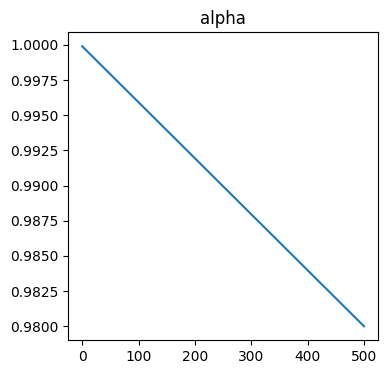

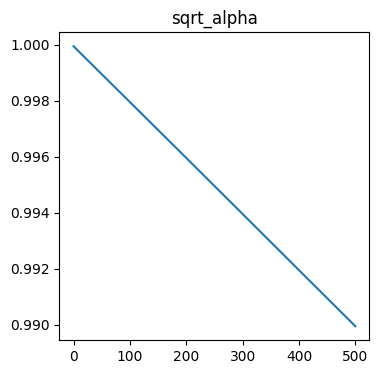

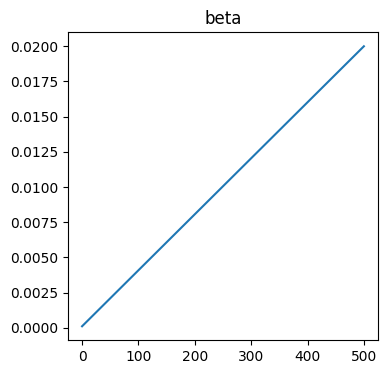

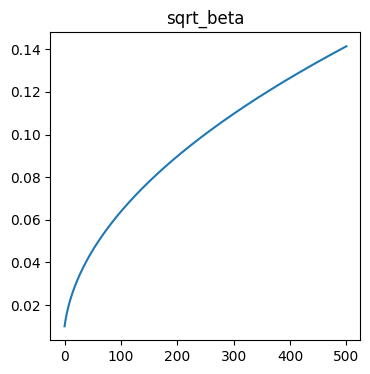

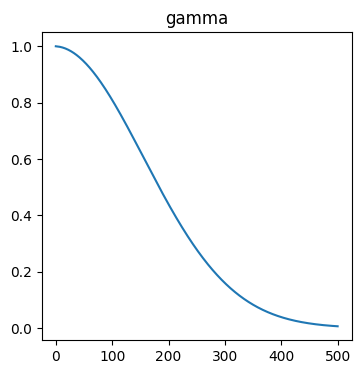

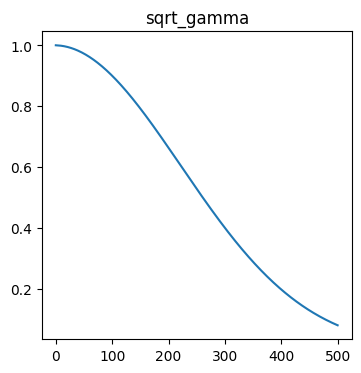

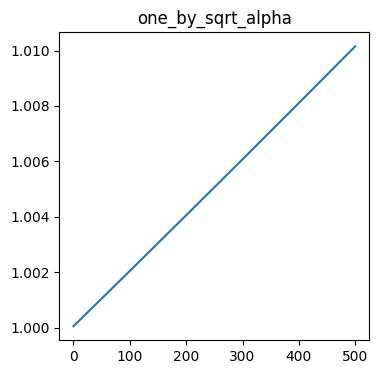

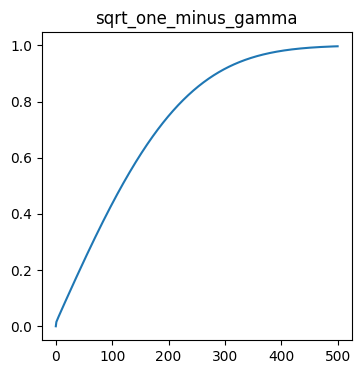

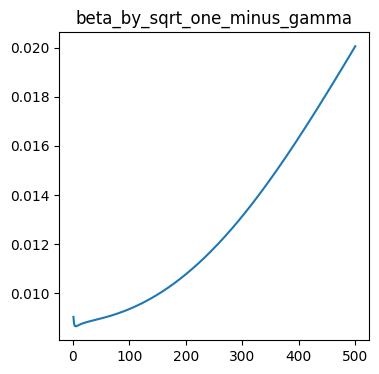

In [5]:
df.show_noise_schedule2()

## Noise schedule

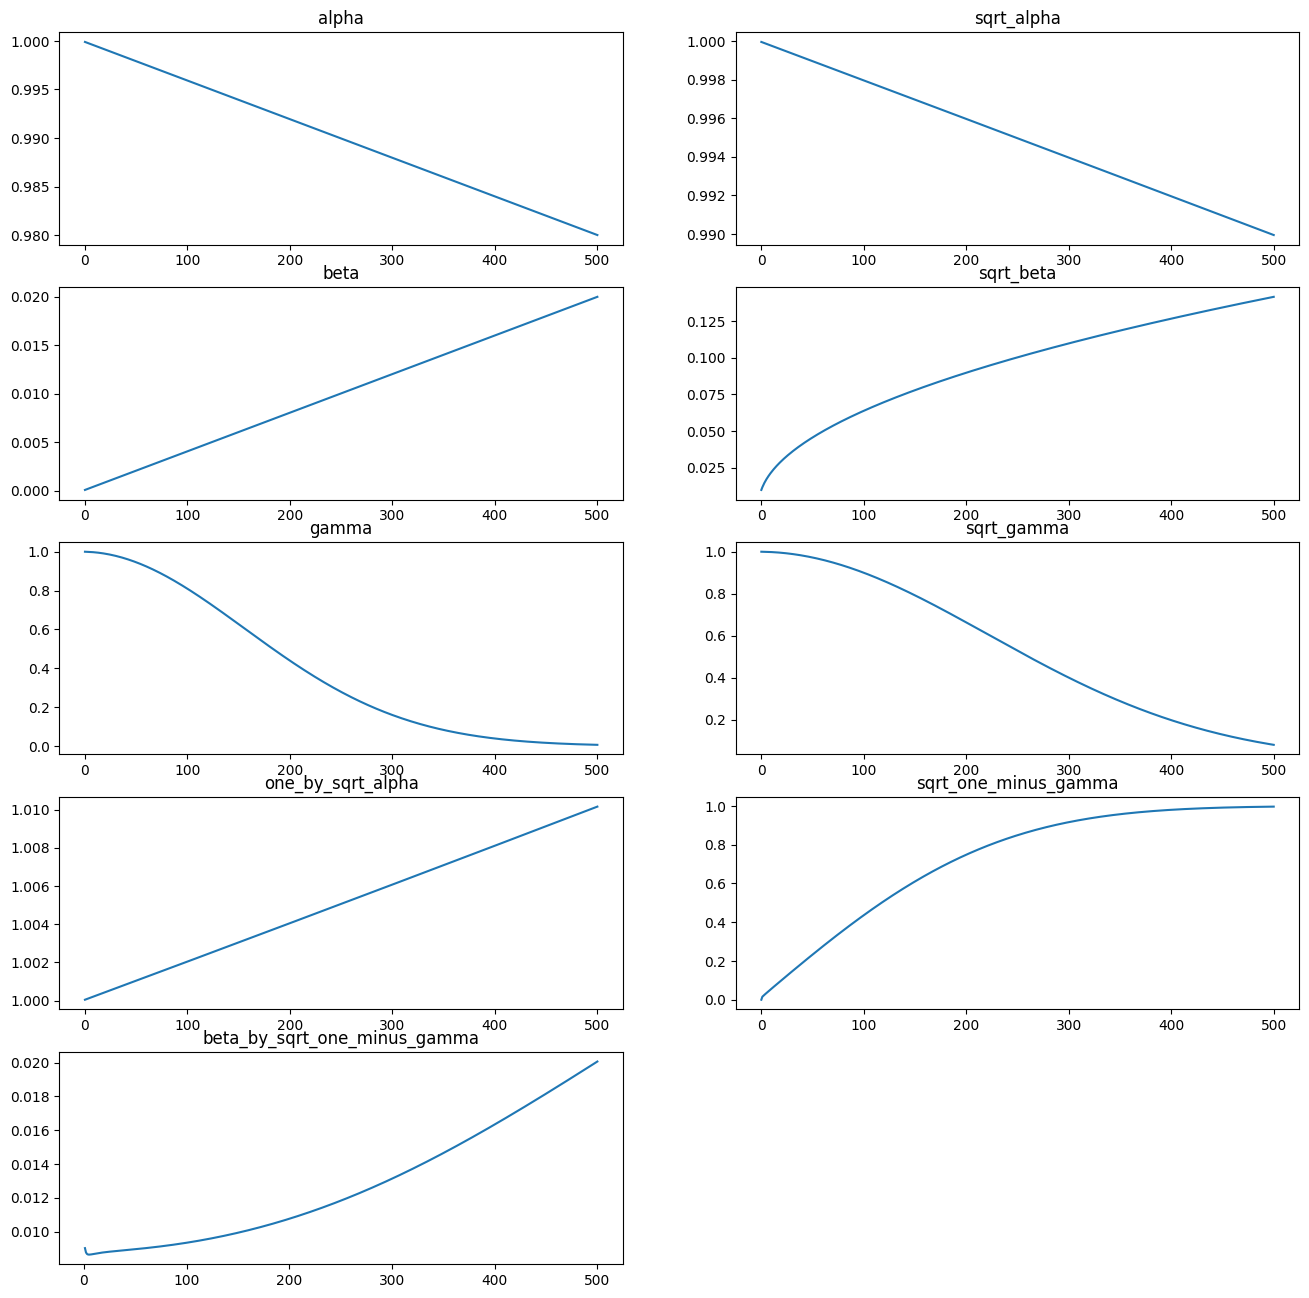

In [6]:
df.show_noise_schedule()

# Custom Dataset Class

In [7]:
class CustomDataset(Dataset):
  def __init__(self, filename, transform=None):
    file = np.load(filename, allow_pickle = True)
    self.dataset = file.item()['dataset']
    self.len = file.item()['length']

    if transform is None:
      self.transform = transforms.ToTensor()
    else:
      self.transform = transform

  # Return the number of images in the dataset
  def __len__(self):
    return self.len

  # Get the image and label at a given index
  def __getitem__(self, idx):
    # Return the image and label as a tuple
    image = self.transform(self.dataset[idx]['img'])
    return (image, self.dataset[idx]['label'])

  # Get the shapes of datas and labels
  def getshapes(self):
    # return shapes of data and labels
    return self.dataset['shape']

# Loader Dataset

In [8]:
# DataSet path
#dataset_data_path = '/content/drive/MyDrive/share_with_me/TFG 23-24 - Modelos de difusion/Diffusion Models/datasets/conceptual_captions/dataset_conceptual_captions.npy'
#dataset_data_path = '/content/drive/MyDrive/TFG 23-24 - Modelos de difusion/Diffusion Models/datasets/conceptual_captions/dataset_conceptual_captions_flower.npy'
dataset_data_path = './dataset/dataset_conceptual_captions_lite.npy'
# load dataset
dataset = CustomDataset(dataset_data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
print(len(dataset))

108


# show sample

## function

In [9]:
# display samples from a dataset randomly using Gaussian distribution
def show_samples(dataset, num_samples=40, cols=1):
  """ Plots some samples from the dataset """
  rows = int(num_samples / cols)
  if num_samples%cols!=0:
    rows += 1
  plt.figure(figsize=(16,rows*2))
  random_idx = torch.randint(0,len(dataset),(num_samples,))
  for i, idx in enumerate(random_idx):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    img, curr_label = dataset[int(idx)]
    #img = df.unorm(img)
    plt.title(curr_label)
    plt.imshow(img.permute(1,2,0))

## Try function

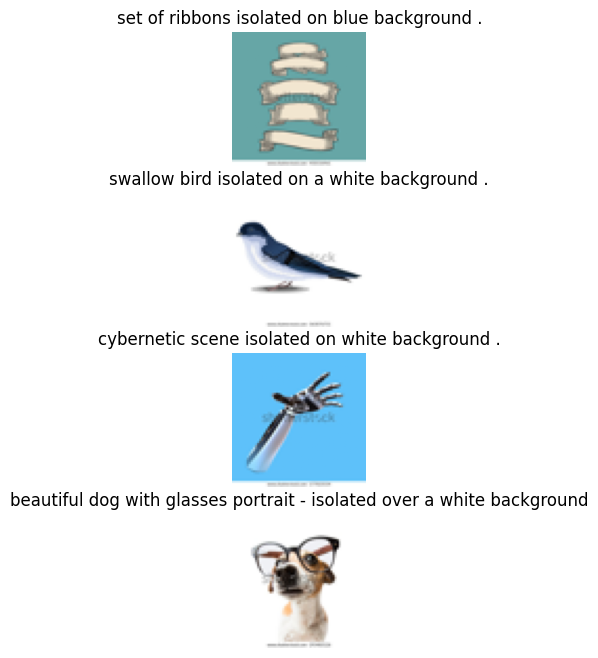

In [27]:
show_samples(dataset, num_samples=4)

# simulate_forward_diffusion

/tmp/ipykernel_3626469/478970820.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


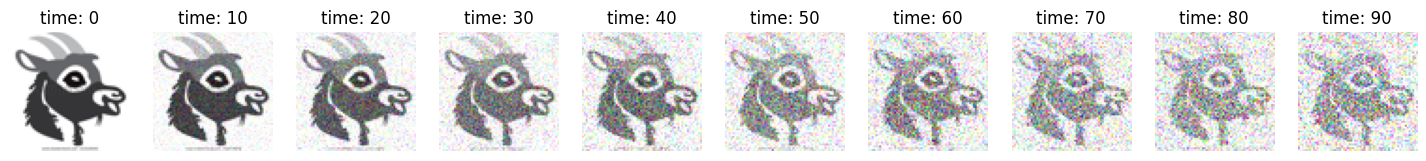

In [11]:
df.simulate_forward_diffusion(100, dataset)

/tmp/ipykernel_3626469/478970820.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


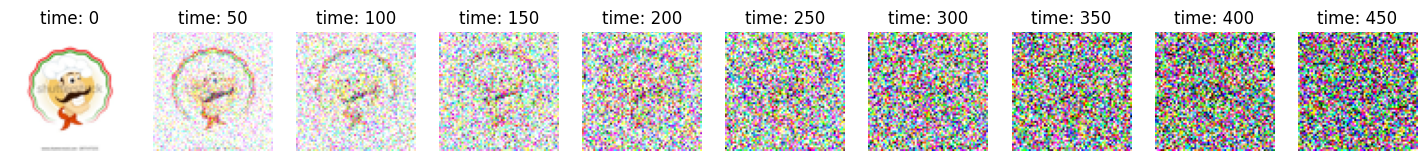

In [12]:
df.simulate_forward_diffusion(timesteps, dataset)

# T5

In [6]:
#Código original para uso de T5:

import torch
from einops import rearrange
from transformers import T5Tokenizer, T5EncoderModel

MAX_LENGTH = MAX_TEXT_LEN

# Variants: https://huggingface.co/docs/transformers/model_doc/t5v1.1. 1.1 versions must be finetuned.
T5_version = {'tokenizer': None, 'model': None, 'handle': 't5-small', 'dim': 512, 'size': .24}

# Fast tokenizers: https://huggingface.co/docs/transformers/main_classes/tokenizer
def _check_downloads():
    if T5_version['tokenizer'] is None:
        T5_version['tokenizer'] = T5Tokenizer.from_pretrained(T5_version['handle'])
    if T5_version['model'] is None:
        T5_version['model'] = T5EncoderModel.from_pretrained(T5_version['handle'])


def t5_encode_text(text, max_length=MAX_LENGTH):

    _check_downloads()
    tokenizer = T5_version['tokenizer']
    model = T5_version['model']

    # Move to cuda is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model = model.to(device)
    else:
        device = torch.device('cpu')

    # Tokenize text
    tokenized = tokenizer.batch_encode_plus(
        text,
        padding='longest',
        max_length=max_length,
        truncation=True,
        return_tensors="pt",  # Returns torch.tensor instead of python integers
    )

    input_ids = tokenized.input_ids.to(device)
    attention_mask = tokenized.attention_mask.to(device)

    model.eval()

    # Don't need gradient - T5 frozen during Imagen training
    with torch.no_grad():
        t5_output = model(input_ids=input_ids, attention_mask=attention_mask)
        final_encoding = t5_output.last_hidden_state.detach()

    # Wherever the encoding is masked, make equal to zero
    final_encoding = final_encoding.masked_fill(~rearrange(attention_mask, '... -> ... 1').bool(), 0.)

    return final_encoding, attention_mask.bool()


def get_encoded_dim() -> int:
    """
    Gets the encoding dimensionality of a given T5 encoder.
    """
    return T5_version['dim']

In [7]:
print(t5_encode_text("Hola mundo")[0].shape)
print(t5_encode_text("Hola mundo")[0])


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


torch.Size([10, 3, 512])
tensor([[[-0.0289, -0.0115,  0.0770,  ..., -0.0900,  0.0133, -0.3054],
         [ 0.0808,  0.1121, -0.2322,  ..., -0.1161,  0.0053, -0.0249],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0102, -0.0019, -0.0439,  ..., -0.0878,  0.0596, -0.0724],
         [ 0.1852,  0.0992,  0.2386,  ..., -0.1302,  0.0412, -0.1472],
         [-0.0056,  0.1004, -0.1909,  ..., -0.0005,  0.0257,  0.1698]],

        [[ 0.0238, -0.0489, -0.0368,  ..., -0.1432,  0.0202,  0.0465],
         [ 0.0577,  0.0634,  0.2401,  ..., -0.0079, -0.1841, -0.1062],
         [-0.0591,  0.0347, -0.1815,  ..., -0.0024, -0.0116,  0.2303]],

        ...,

        [[-0.0289, -0.0352, -0.0830,  ..., -0.0994,  0.0114,  0.0515],
         [ 0.0878,  0.1222,  0.2787,  ..., -0.1322, -0.1381, -0.1977],
         [ 0.1025,  0.0621, -0.2184,  ...,  0.0460,  0.0417,  0.1913]],

        [[ 0.0822, -0.0060, -0.0954,  ..., -0.1178, -0.0073,  0.0820],
         [ 0.1374,  0.2011,  0

In [8]:
def prob_mask_like(shape: tuple, prob: float, device: torch.device) -> torch.Tensor:
    """
    For classifier free guidance. Creates a boolean mask for given input shape and probability of `True`.

    :param shape: Shape of mask.
    :param prob: Probability of True. In interval [0., 1.].
    :param device: Device to put the mask on. Should be the same as that of the tensor which it will be used on.
    :return: The mask.
    """
    if prob == 1:
        return torch.ones(shape, device=device, dtype=torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device=device, dtype=torch.bool)
    else:
        return torch.zeros(shape, device=device).float().uniform_(0, 1) < prob

# Model (U-Net)

This model will be train for predict the noise of image

In [9]:
class LayerNorm(nn.Module):
    """
    LayerNorm
    """
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer('beta', torch.zeros(dim))

    def forward(self, x: torch.tensor) -> torch.tensor:
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)



class CrossAttention(nn.Module):
    """
    Multi-headed cross attention.
    """

    def __init__(
            self,
            dim: int,
            *,
            context_dim: int = None,
            dim_head: int = 64,
            heads: int = 8,
            norm_context: bool = False
    ):
        """
        :param dim: Input dimensionality.
        :param context_dim: Context dimensionality.
        :param dim_head: Dimensionality for each attention head.
        :param heads: Number of attention heads.
        :param norm_context: Whether to LayerNorm the context.
        """
        super().__init__()
        self.scale = dim_head ** -0.5   # 1/sqrt(dh)
        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = context_dim if context_dim is not None else dim

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else None

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias=False),
            LayerNorm(dim)
        )

    def forward(self, x: torch.tensor, context: torch.tensor, mask: torch.tensor = None) -> torch.tensor:
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        if self.norm_context is not None:
          context = self.norm_context(context)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim=-1))

        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> b h n d', h=self.heads)

        # add null key / value for classifier free guidance in prior net

        nk, nv = repeat_many(self.null_kv.unbind(dim=-2), 'd -> b h 1 d', h=self.heads, b=b)

        k = torch.cat((nk, k), dim=-2)
        v = torch.cat((nv, v), dim=-2)

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        max_neg_value = -torch.finfo(sim.dtype).max

        if mask is not None:
            mask = F.pad(mask, (1, 0), value=True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        attn = sim.softmax(dim=-1, dtype=torch.float32)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)



class Block(nn.Module):
  def __init__(self, in_channels, out_channels, time_cond_dim=None, text_cond_dim=None):
    super().__init__()

    self.time_fc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(time_cond_dim, 2*out_channels)
    ) if time_cond_dim is not None else None

    self.attn = EinopsToAndFrom('b c h w', 'b (h w) c',
                CrossAttention(dim=out_channels, context_dim=text_cond_dim, heads=4)
    ) if text_cond_dim is not None else None

    # First convolutional layer
    self.conv1 = nn.Sequential(
        nn.BatchNorm2d(in_channels),   # Batch normalization
        nn.ReLU(),   # ReLU activation function
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, device=device)   # 3x3 kernel with stride 1 and padding 1
        )

    self.norm = nn.BatchNorm2d(out_channels)
    # Second convolutional layer
    self.conv2 = nn.Sequential(
        nn.ReLU(),   # ReLU activation function
        nn.Conv2d(out_channels, out_channels, 3, 1, 1)   # 3x3 kernel with stride 1 and padding 1
        )

  def forward(self, x, t=None, c=None):
    x = self.conv1(x)

    if self.attn is not None and c is not None:
      x = x + self.attn(x, context=c)
    x = self.norm(x)

    if self.time_fc is not None and t is not None:
      t = self.time_fc(t)
      t = rearrange(t, 'b c -> b c 1 1')  # (b, 2c, 1, 1)
      scale, shift = t.chunk(2, dim=1)                  # (b, c, 1, 1) *2
      x = x * (scale + 1) + shift

    return self.conv2(x)



class UnetUp(nn.Module):
  def __init__(self, in_channels, out_channels, time_cond_dim=None, text_cond_dim=None):
    super(UnetUp, self).__init__()
    # The model consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
    self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
    self.b1 = Block(out_channels, out_channels, time_cond_dim=time_cond_dim, text_cond_dim=text_cond_dim)
    self.b2 = Block(out_channels, out_channels, time_cond_dim=time_cond_dim)

  def forward(self, x, skip, t=None, c=None):
    # Concatenate the input tensor x with the skip connection tensor along the channel dimension
    x = torch.cat((x, skip), dim=1)

    # Pass the concatenated tensor through the sequential model and return the output
    x = self.up(x)
    x = self.b1(x, t=t, c=c)
    x = self.b2(x, t=t, c=c)
    return x



class UnetDown(nn.Module):
  def __init__(self, in_channels, out_channels, time_cond_dim=None, text_cond_dim=None):
    super(UnetDown, self).__init__()
    # Each block consists of two Block layers, followed by a MaxPool2d layer for downsampling
    self.b1 = Block(in_channels, out_channels, time_cond_dim=time_cond_dim)
    self.b2 = Block(out_channels, out_channels, time_cond_dim=time_cond_dim, text_cond_dim=text_cond_dim)

    self.maxpool = nn.MaxPool2d(2)

  def forward(self, x, t=None, c=None):
    x = self.b1(x, t, c)
    x = self.b2(x, t, c)
    return self.maxpool(x)



class EmbedFC(nn.Module):
  def __init__(self, input_dim, emb_dim):
    super(EmbedFC, self).__init__()
    #This class defines a generic one layer feed-forward neural network for embedding input data of
    #dimensionality input_dim to an embedding space of dimensionality emb_dim.
    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.model = nn.Sequential(
        nn.Linear(input_dim, emb_dim),
        nn.ReLU(),
        nn.Linear(emb_dim, emb_dim)
        )

  def forward(self, x):
    # flatten the input tensor
    x = x.view(-1, self.input_dim)
    # apply the model layers to the flattened tensor
    return self.model(x).view(-1, self.emb_dim, 1, 1)



class SinusoidalPosEmb(nn.Module):
    '''
    Generates sinusoidal positional embedding tensor. In this case, position corresponds to time. For more information
        on sinusoidal embeddings, see ["Positional Encoding - Additional Details"](https://www.assemblyai.com/blog/how-imagen-actually-works/#timestep-conditioning).
    '''
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        :param x: Tensor of positions (i.e. times) to generate embeddings for.
        :return: T x D tensor where T is the number of positions/times and D is the dimensionality of the embedding
            space
        """
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=x.device) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim=-1).squeeze()



class TimeConditioningLayer(nn.Module):
  def __init__(self, dim, emb_dim=None):
    super().__init__()
    NUM_TIME_TOKENS = 2  # Number of time tokens to use in conditioning tensor
    if emb_dim is None:
      emb_dim = dim

    # Maps time to time hidden state
    self.to_time_hiddens = nn.Sequential(
        SinusoidalPosEmb(dim),
        nn.Linear(dim, emb_dim),
        nn.ReLU()
    )
    # Maps time hidden state to time conditioning (non-attention)
    self.to_time_cond = nn.Sequential(
        nn.Linear(emb_dim, emb_dim)
    )
    # Maps time hidden states to time tokens for main conditioning tokens (attention)
    self.to_time_tokens = nn.Sequential(
        nn.Linear(emb_dim, dim * NUM_TIME_TOKENS),
        Rearrange('b (r d) -> b r d', r=NUM_TIME_TOKENS)
    )

  def forward(self, time: torch.tensor, ) -> tuple[torch.tensor, torch.tensor]:
    '''
    Generate t and time_tokens

    :param time: Tensor of shape (b,). The timestep for each image in the batch.
    :return: tuple(t, time_tokens)
        t: Tensor of shape (b, time_cond_dim) where `time_cond_dim` is 4x the UNet `dim`, or 8 if conditioning
        on lowres image.
        time_tokens: Tensor of shape (b, NUM_TIME_TOKENS, dim), where `NUM_TIME_TOKENS` defaults to 2.
    '''
    time_hiddens = self.to_time_hiddens(time)
    t = self.to_time_cond(time_hiddens)
    time_tokens = self.to_time_tokens(time_hiddens)
    return t, time_tokens



class TextConditioningLayer(nn.Module):
  def __init__(self, dim, emb_dim=None):
    super().__init__()
    self.max_text_len = MAX_TEXT_LEN
    if emb_dim is None:
      emb_dim = 4*dim

    self.norm_cond = nn.LayerNorm(dim)
    self.text_embed_dim = get_encoded_dim()
    self.text_to_cond = nn.Linear(self.text_embed_dim, dim)

    self.null_text_embed = nn.Parameter(torch.randn(1, MAX_TEXT_LEN, dim))
    self.null_text_hidden = nn.Parameter(torch.randn(1, emb_dim))

    # For injecting text information into time conditioning (non-attention)
    self.to_text_non_attn_cond = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, emb_dim),
        nn.ReLU(),
        nn.Linear(emb_dim, emb_dim)
    )

  def forward(
            self,
            text_embeds: torch.tensor,
            cond_drop_prob: float,
            device: torch.device,
            text_mask: torch.tensor,
            t: torch.tensor,
            time_tokens: torch.tensor
    ) -> tuple[torch.tensor, torch.tensor]:
        '''
        Condition on text.

        :param text_embeds: Text embedding from T5 encoder. Shape (b, mw, ed), where

            :code:`b` is the batch size,

            :code:`mw` is the maximum number of words in a caption in the batch, and

            :code:`ed` is the T5 encoding dimension.
        :param cond_drop_prob: Probability of conditional dropout for `classifier-free guidance <https://www.assemblyai.com/blog/how-imagen-actually-works/#classifier-free-guidance>`_
        :param device: Device to use.
        :param text_mask: Text mask for text embeddings. Shape (b, minimagen.t5.MAX_LENGTH)
        :param t: Time conditioning tensor.
        :param time_tokens: Time conditioning tokens.
        :return: tuple(t, c)

            :code:`t`: Time conditioning tensor

            :code:`c`: Main conditioning tokens
        '''
        text_tokens = None
        if text_embeds is not None:

            # Project the text embeddings to the conditioning dimension `cond_dim`.
            text_tokens = self.text_to_cond(text_embeds)

            # Truncate the tokens to have the maximum number of allotted words.
            text_tokens = text_tokens[:, :self.max_text_len]

            # Pad the text tokens up to self.max_text_len if needed
            text_tokens_len = text_tokens.shape[1]
            remainder = self.max_text_len - text_tokens_len
            if remainder > 0:
                text_tokens = F.pad(text_tokens, (0, 0, 0, remainder))

            # Prob. mask for clf-free guidance conditional dropout. Tells which elts in the batch to keep. Size (b,).
            text_keep_mask = prob_mask_like((batch_size,), 1 - cond_drop_prob, device=device)

            # Combines T5 and clf-free guidance masks
            text_keep_mask_embed = rearrange(text_keep_mask, 'b -> b 1 1')
            if text_mask is not None:
                if remainder > 0:
                    text_mask = F.pad(text_mask, (0, remainder), value=False)

                text_mask = rearrange(text_mask, 'b n -> b n 1')  # (b, self.max_text_len, 1)
                text_keep_mask_embed = text_mask & text_keep_mask_embed  # (b, self.max_text_len, 1)

            # Creates NULL tensor of size (1, self.max_text_len, cond_dim)
            null_text_embed = self.null_text_embed.to(text_tokens.dtype)  # for some reason pytorch AMP not working

            # Replaces masked elements with NULL
            text_tokens = torch.where(
                text_keep_mask_embed,
                text_tokens,
                null_text_embed
            )

            # Extra non-attention conditioning by projecting and then summing text embeddings to time (text hiddens)
            # Pool the text tokens along the word dimension.
            mean_pooled_text_tokens = text_tokens.mean(dim=-2)

            # Project to `time_cond_dim`
            text_hiddens = self.to_text_non_attn_cond(mean_pooled_text_tokens)  # (b, cond_dim) -> (b, time_cond_dim)

            null_text_hidden = self.null_text_hidden.to(t.dtype)

            # Drop relevant conditioning info as demanded by clf-free guidance mask
            text_keep_mask_hidden = rearrange(text_keep_mask, 'b -> b 1')
            text_hiddens = torch.where(
                text_keep_mask_hidden,
                text_hiddens,
                null_text_hidden
            )

            # Add this conditioning to our `t` tensor
            t = t + text_hiddens
        # main conditioning tokens `c` - concatenate time/text tokens
        c = time_tokens if text_tokens is None else torch.cat((time_tokens, text_tokens), dim=-2)
        # normalize conditioning tokens
        c = self.norm_cond(c)
        return t, c

In [10]:
class Unet(nn.Module):
  def __init__(self, in_channels, n_feat=128, n_cfeat=512, height=64, cond_drop_prob=0.1):  # cfeat - context features
    super(Unet, self).__init__()
    # number of input channels, number of intermediate feature maps and number of classes
    self.in_channels = in_channels
    self.n_feat = n_feat
    self.n_cfeat = n_cfeat
    self.h = height  #assume h == w.
    self.cond_drop_prob = cond_drop_prob
    time_cond_dim = 4*n_feat

    # Embed the timestep and context labels with a one-layer fully connected neural network
    self.time_cond = TimeConditioningLayer(n_feat, time_cond_dim)
    self.text_cond = TextConditioningLayer(n_feat)

    # Initialize the initial convolutional layer                                                                # in    (b, 3, 64, 64)
    self.init_conv = Block(in_channels, n_feat//4)                                                              # init  (b, 32, 64, 64)

    # Initialize the down-sampling path of the U-Net
    self.down = nn.ModuleList([UnetDown(n_feat//4, n_feat//2, time_cond_dim=time_cond_dim),                     # down1 (b, 64, 32, 32)
                 UnetDown(n_feat//2, n_feat, time_cond_dim=time_cond_dim),                                      # down2 (b, 128, 16, 16)
                 UnetDown(n_feat, n_feat, time_cond_dim=time_cond_dim, text_cond_dim=n_feat)])                  # down3 (b, 128, 8, 8)

    self.mid = nn.ModuleList([Block(n_feat, n_feat, time_cond_dim=time_cond_dim, text_cond_dim=n_feat),
                             Block(n_feat, n_feat, time_cond_dim=time_cond_dim, text_cond_dim=n_feat)])         # mid  (b, 128, 8, 8)

    # Initialize the up-sampling path of the U-Net
    self.up = nn.ModuleList([UnetUp(2*n_feat, n_feat, time_cond_dim=time_cond_dim, text_cond_dim=n_feat),       # up1 (b, 128, 16, 16)
               UnetUp(2*n_feat, n_feat//2, time_cond_dim=time_cond_dim),                                        # up2 (b, 64, 32, 32)
               UnetUp(n_feat, n_feat//4, time_cond_dim=time_cond_dim)])                                         # up3 (b, 32, 64, 64)

    # Initialize the final convolutional layers to map to the same number of channels as the input image
    self.out = nn.Sequential(
        nn.Conv2d(n_feat//4, n_feat//8, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(n_feat//8, self.in_channels, 3, 1, 1), # map to same number of channels as input
    )                                                                                                    # out (b, 3, 64, 64)


  def forward(self, x, time, t_emb=None, t_mask=None):
    """
    x : (batch, 3, h, w) : input image
    t : (batch,)      : time step
    t_emb  : (batch, n_words, n_cfeat)   : text embed
    t_mask : (batch, n_words, n_cfeat)   : text mask
    """
    # x is the input image, t_emb is the context label, t is the timestep, context_mask says which samples to block the context on
    t, time_tokens = self.time_cond(time)
    t, c = self.text_cond(text_embeds=t_emb, text_mask=t_mask, cond_drop_prob=self.cond_drop_prob,
                     device=device, t=t, time_tokens=time_tokens)

    # pass the input image through the initial convolutional layer
    x = self.init_conv(x)
    # pass the result through the down-sampling path
    x_down = [x]
    for i, down in enumerate(self.down):
      x_down.append(down(x_down[i], t, c))
    x_down.pop(0)

    x = self.mid[0](x_down[-1], t, c)
    x = self.mid[1](x, t, c)

    for i, up in enumerate(self.up):
      x = up(x, x_down[-i-1], t, c)

    return self.out(x)

# Training

## optimizer and loss function

In [18]:
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Start training

In [19]:
training_steps = 0
model.train()
for epoch in range(n_epoch):
  if epoch % 100 == 0:
      print("------ epoch {:03d} ------".format(epoch + 1))

  # linearly decay learning rate
  optimizer.param_groups[0]['lr'] = learning_rate*(1-(epoch/n_epoch))
  total_loss = 0
  for x_0, labels in dataloader:   # x_0: images
    optimizer.zero_grad()
    x_0 = x_0.to(device)
    # perturb data
    noise = torch.randn_like(x_0).to(device)
    t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
    x_t = df.noise_image(x_0, t, noise).to(device)
    t_emb, t_mask = t5_encode_text(labels)
    # use network to recover noise
    pred_noise = model(x_t, t / timesteps, t_emb=t_emb, t_mask=t_mask)

    # loss is measures the element-wise mean squared error between the predicted and true noise
    loss = F.mse_loss(pred_noise, noise)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    training_steps+=1
    if (training_steps%100) == 0:
      print("Total train step: {}, Loss: {}".format(training_steps,loss))
  #print("Total Loss: {}".format(total_loss))
  # save model periodically
  if epoch%100==0 or epoch == int(n_epoch-1):
    torch.save(model.state_dict(), save_dir + "model_{:03d}.pth".format(epoch + 1))
    print('saved model at ' + save_dir + "model_{:03d}.pth".format(epoch + 1))

model.eval()

------ epoch 001 ------
saved model at ./weights_pocho/model_001.pth
Total train step: 100, Loss: 0.5904145240783691
Total train step: 200, Loss: 0.4409697949886322
Total train step: 300, Loss: 0.3562344014644623
------ epoch 101 ------
saved model at ./weights_pocho/model_101.pth
Total train step: 400, Loss: 0.2768403887748718
Total train step: 500, Loss: 0.21134965121746063
Total train step: 600, Loss: 0.16679540276527405
------ epoch 201 ------
saved model at ./weights_pocho/model_201.pth
Total train step: 700, Loss: 0.1535680741071701
Total train step: 800, Loss: 0.12418264150619507
Total train step: 900, Loss: 0.14318545162677765
------ epoch 301 ------
saved model at ./weights_pocho/model_301.pth
Total train step: 1000, Loss: 0.11932175606489182
Total train step: 1100, Loss: 0.14266535639762878
Total train step: 1200, Loss: 0.12101134657859802
------ epoch 401 ------
saved model at ./weights_pocho/model_401.pth
Total train step: 1300, Loss: 0.12487904727458954
Total train step: 1

Unet(
  (time_cond): TimeConditioningLayer(
    (to_time_hiddens): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): ReLU()
    )
    (to_time_cond): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
    )
    (to_time_tokens): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Rearrange('b (r d) -> b r d', r=2)
    )
  )
  (text_cond): TextConditioningLayer(
    (norm_cond): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (text_to_cond): Linear(in_features=512, out_features=128, bias=True)
    (to_text_non_attn_cond): Sequential(
      (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (init_conv): Block(
    (conv1): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affin

# Sampling

In [17]:
batch_size = 4
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
save_dir2= './weights2.5/'
model.load_state_dict(torch.load(save_dir2+"model_201.pth", map_location=device))

<All keys matched successfully>

In [ ]:
model.eval()
a = ['seamless pattern pink and blue flowers in a flat style on a green background', 
     'illustration of a isolated ball on a blue background', 
     'red flowers on white background', 
     'mountain']
samples = df.sample_ddpm_context(model, 4, a)
samples = samples.detach().cpu().numpy()
for i, img in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    img = df.unorm(img)
    plt.imshow(img.permute(1,2,0))

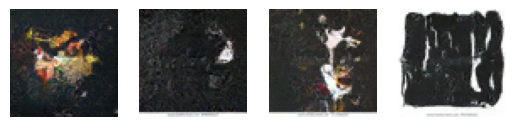

In [18]:
model.eval()
a = ['night in the city on a dark blue background', 
     'icon isolated white on a black background', 
     'illustration of a chrismas tree on a red background', 
     'vector silhouette of a couple dancing on a white background']
samples = df.sample_ddpm_context(model, 4, a)
samples = samples.detach().cpu().numpy()
for i, img in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    img = df.unorm(img)
    plt.imshow(img.permute(1,2,0))

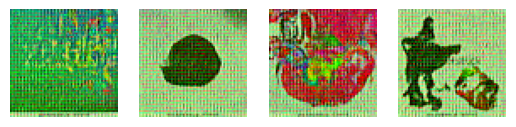

In [19]:
model.train()
a = ['night in the city on a dark blue background', 
     'icon isolated white on a black background', 
     'illustration of a chrismas tree on a red background', 
     'vector silhouette of a couple dancing on a white background']
samples = df.sample_ddpm_context(model, 4, a)
samples = samples.detach().cpu().numpy()
for i, img in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    img = df.unorm(img)
    plt.imshow(img.permute(1,2,0))

In [ ]:
df.draw_samples_process()

In [ ]:
t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
t = torch.tensor(t,)
t.shape

In [ ]:
model.intermediate

In [ ]:
a=torch.randn(size=(16,64,256,256))
b=torch.randn(size=(16,64,256,1))
c=torch.randn(size=(16,64,1,1))
a*c+b

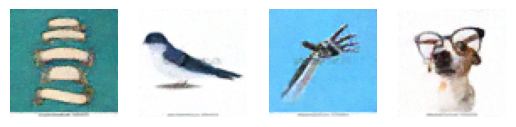

In [55]:
model.eval()
a = ['set of ribbons isolated on blue background .', 
     'swallow bird isolated on a white background .', 
     'cybernetic scene isolated on white background .', 
     'beautiful dog with glasses portrait - isolated over a white background .']
samples = df.sample_ddpm_context(model, 4, a)
samples = samples.detach().cpu().numpy()
for i, img in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    img = df.unorm(img)
    plt.imshow(img.permute(1,2,0))

In [ ]:
for i in range(len(dataset)):
    print(dataset[i][1])

illustration of gray head of goat on a white background
vector illustration of green waves on a white background
sitting black cat isolated over the white background
bright shiny reflective vintage gold number in a 3d illustration with a retro golden color and metallic glossy classic font isolated on a white background with clipping path .
black and white grunge background .
letter j logo symbol in the colorful circle on black background .
cybernetic scene isolated on white background .
bowling ball reflected on a white background
hand drawn set on a blue background .
set of tasty and useful food of corn isolated on a white background .
map of the state on a white background .
penguins on a blue background .
vector abstract hatched map with spiral lines isolated on a white background .
safe deposit with money around it on a white background photo
isolated christmas tree with snow and presents on a white background
cute girl and boy with hearts over pink background with lettering .
vect

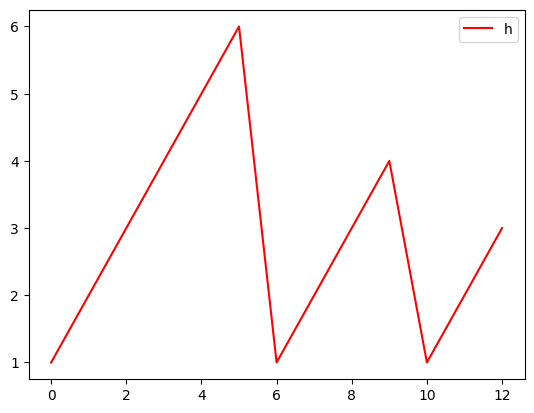

In [7]:
import matplotlib.pyplot as plt
lista = [1,2,3,4,5,6,1,2,3,4,1,2,3]
plt.figure()

plt.plot(lista,c="red",label="que")
plt.legend("h")
plt.savefig('time.png')